# EDA & Prediction on Data Of India General Election 2019 
Data Source: (https://www.kaggle.com/datasets/prakrutchauhan/indian-candidates-for-general-election-2019)



### Installing required Python lib...

In [71]:
#!pip install numpy
#!pip install pandas

In [72]:
#!pip install matplotlib
#!pip install seaborn
#!pip install plotly

In [73]:
#!pip install sklearn
#!pip install xgboost

### Importing required lib...

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objects as go
import plotly.offline as py
import plotly.express as px

py.init_notebook_mode(connected=True)
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,train_test_split

# Plot should appear inside the jupyter notebook
%matplotlib inline


### 1.0) Importing & Analysing Data 

In [75]:
df_elec = pd.read_csv("Dataset/IndianElections/LS_2.0.csv")
df_elec.head()

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,CRIMINAL\nCASES,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,GENERAL\nVOTES,POSTAL\nVOTES,TOTAL\nVOTES,OVER TOTAL ELECTORS \nIN CONSTITUENCY,OVER TOTAL VOTES POLLED \nIN CONSTITUENCY,TOTAL ELECTORS
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,"Rs 30,99,414\n ~ 30 Lacs+","Rs 2,31,450\n ~ 2 Lacs+",376892,482,377374,25.330684,35.468248,1489790
1,Telangana,ADILABAD,Godam Nagesh,0,TRS,Car,MALE,0,54.0,ST,Post Graduate,"Rs 1,84,77,888\n ~ 1 Crore+","Rs 8,47,000\n ~ 8 Lacs+",318665,149,318814,21.399929,29.964370,1489790
2,Telangana,ADILABAD,RATHOD RAMESH,0,INC,Hand,MALE,3,52.0,ST,12th Pass,"Rs 3,64,91,000\n ~ 3 Crore+","Rs 1,53,00,000\n ~ 1 Crore+",314057,181,314238,21.092771,29.534285,1489790
3,Telangana,ADILABAD,NOTA,0,NOTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13030,6,13036,0.875023,1.225214,1489790
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,"Rs 7,42,74,036\n ~ 7 Crore+","Rs 86,06,522\n ~ 86 Lacs+",644459,2416,646875,33.383823,56.464615,1937690


In [76]:
df_elec.columns

Index(['STATE', 'CONSTITUENCY', 'NAME', 'WINNER', 'PARTY', 'SYMBOL', 'GENDER',
       'CRIMINAL\nCASES', 'AGE', 'CATEGORY', 'EDUCATION', 'ASSETS',
       'LIABILITIES', 'GENERAL\nVOTES', 'POSTAL\nVOTES', 'TOTAL\nVOTES',
       'OVER TOTAL ELECTORS \nIN CONSTITUENCY',
       'OVER TOTAL VOTES POLLED \nIN CONSTITUENCY', 'TOTAL ELECTORS'],
      dtype='object')

In [77]:
#Rename columns
df_elec = df_elec.rename(columns={"CRIMINAL\nCASES": "criminal_cases", "GENERAL\nVOTES": "general_votes","POSTAL\nVOTES":"postal_votes","TOTAL\nVOTES":"total_votes"
                                 ,"OVER TOTAL ELECTORS \nIN CONSTITUENCY":"pct_over_total_electors_in_const"
                                 ,"OVER TOTAL VOTES POLLED \nIN CONSTITUENCY":"pct_over_total_vote_poll_in_const"})
df_elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   STATE                              2263 non-null   object 
 1   CONSTITUENCY                       2263 non-null   object 
 2   NAME                               2263 non-null   object 
 3   WINNER                             2263 non-null   int64  
 4   PARTY                              2263 non-null   object 
 5   SYMBOL                             2018 non-null   object 
 6   GENDER                             2018 non-null   object 
 7   criminal_cases                     2018 non-null   object 
 8   AGE                                2018 non-null   float64
 9   CATEGORY                           2018 non-null   object 
 10  EDUCATION                          2018 non-null   object 
 11  ASSETS                             2018 non-null   objec

In [78]:
df_elec.isnull().sum()

STATE                                  0
CONSTITUENCY                           0
NAME                                   0
WINNER                                 0
PARTY                                  0
SYMBOL                               245
GENDER                               245
criminal_cases                       245
AGE                                  245
CATEGORY                             245
EDUCATION                            245
ASSETS                               245
LIABILITIES                          245
general_votes                          0
postal_votes                           0
total_votes                            0
pct_over_total_electors_in_const       0
pct_over_total_vote_poll_in_const      0
TOTAL ELECTORS                         0
dtype: int64

==> After Looking at columns, we can see there about 245 rows has NULL values in 8 columns. We will have to understand if there are any pattern

In [79]:
#understand where Symbol is not present
df_elec[df_elec.SYMBOL.isnull()==True]['NAME'].unique()

array(['NOTA'], dtype=object)

==> NOTA is obption where voter has right to use there vote but in case if s/he do not like any candidate from the list, they can put their vote in NOTA (None of The Above)

Since this is NOTA, You wont see details about candidate like Asset, Gender, Age, Education etc.

In [80]:
#This shows Symbol is NULL where there is NOTA - Let's Replace 
df_elec.loc[df_elec.NAME=='NOTA','SYMBOL'] = 'NoNoNo'

In [81]:
df_elec.loc[df_elec.NAME=='NOTA','SYMBOL']

3       NoNoNo
14      NoNoNo
39      NoNoNo
46      NoNoNo
54      NoNoNo
         ...  
2225    NoNoNo
2230    NoNoNo
2235    NoNoNo
2241    NoNoNo
2262    NoNoNo
Name: SYMBOL, Length: 245, dtype: object

In [82]:
df_elec[df_elec.NAME=='NOTA']

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,criminal_cases,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,general_votes,postal_votes,total_votes,pct_over_total_electors_in_const,pct_over_total_vote_poll_in_const,TOTAL ELECTORS
3,Telangana,ADILABAD,NOTA,0,NOTA,NoNoNo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13030,6,13036,0.875023,1.225214,1489790
14,Gujarat,AHMEDABAD WEST,NOTA,0,NOTA,NoNoNo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14580,139,14719,0.895688,1.473030,1643317
39,West Bengal,ALIPURDUARS,NOTA,0,NOTA,NoNoNo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21147,28,21175,1.284592,1.533114,1648383
46,Uttarakhand,ALMORA,NOTA,0,NOTA,NoNoNo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15311,194,15505,1.158985,2.215611,1337808
54,Andhra Pradesh,AMALAPURAM,NOTA,0,NOTA,NoNoNo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16427,41,16468,1.128288,1.333044,1459556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,Tamil Nadu,VIRUDHUNAGAR,NOTA,0,NOTA,NoNoNo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17087,205,17292,1.165028,1.607174,1484256
2230,Andhra Pradesh,VISAKHAPATNAM,NOTA,0,NOTA,NoNoNo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16626,20,16646,0.909966,1.342505,1829300
2235,Andhra Pradesh,VIZIANAGARAM,NOTA,0,NOTA,NoNoNo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29468,33,29501,1.961529,2.413302,1503980
2241,Telangana,WARANGAL,NOTA,0,NOTA,NoNoNo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18764,37,18801,1.127990,1.770886,1666770


In [83]:
df_elec[df_elec.NAME!='NOTA']

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,criminal_cases,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,general_votes,postal_votes,total_votes,pct_over_total_electors_in_const,pct_over_total_vote_poll_in_const,TOTAL ELECTORS
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,"Rs 30,99,414\n ~ 30 Lacs+","Rs 2,31,450\n ~ 2 Lacs+",376892,482,377374,25.330684,35.468248,1489790
1,Telangana,ADILABAD,Godam Nagesh,0,TRS,Car,MALE,0,54.0,ST,Post Graduate,"Rs 1,84,77,888\n ~ 1 Crore+","Rs 8,47,000\n ~ 8 Lacs+",318665,149,318814,21.399929,29.964370,1489790
2,Telangana,ADILABAD,RATHOD RAMESH,0,INC,Hand,MALE,3,52.0,ST,12th Pass,"Rs 3,64,91,000\n ~ 3 Crore+","Rs 1,53,00,000\n ~ 1 Crore+",314057,181,314238,21.092771,29.534285,1489790
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,"Rs 7,42,74,036\n ~ 7 Crore+","Rs 86,06,522\n ~ 86 Lacs+",644459,2416,646875,33.383823,56.464615,1937690
5,Uttar Pradesh,AGRA,Manoj Kumar Soni,0,BSP,Elephant,MALE,0,47.0,SC,Post Graduate,"Rs 13,37,84,385\n ~ 13 Crore+","Rs 2,22,51,891\n ~ 2 Crore+",434199,1130,435329,22.466390,37.999125,1937690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257,Maharashtra,YAVATMAL-WASHIM,Vaishali Sudhakar Yede,0,PHJSP,Whistle,FEMALE,0,28.0,GENERAL,10th Pass,"Rs 11,68,500\n ~ 11 Lacs+","Rs 9,000\n ~ 9 Thou+",20563,57,20620,1.076097,1.755157,1916185
2258,Maharashtra,YAVATMAL-WASHIM,Anil Jayram Rathod,0,IND,SHIP,MALE,0,43.0,GENERAL,Post Graduate,"Rs 48,90,000\n ~ 48 Lacs+","Rs 10,20,000\n ~ 10 Lacs+",14661,25,14686,0.766419,1.250060,1916185
2259,Telangana,ZAHIRABAD,B.B.PATIL,1,TRS,Car,MALE,18,63.0,GENERAL,Graduate,"Rs 1,28,78,51,556\n ~ 128 Crore+","Rs 1,15,35,000\n ~ 1 Crore+",434066,178,434244,28.975369,41.574183,1498666
2260,Telangana,ZAHIRABAD,MADAN MOHAN RAO,0,INC,Hand,MALE,0,49.0,GENERAL,Post Graduate,"Rs 90,36,63,001\n ~ 90 Crore+",Rs 0\n ~,427900,115,428015,28.559732,40.977823,1498666


In [84]:
#It seems whereever there is NOTA, Values are blank - Let's Fix them where possible
df_elec.loc[df_elec.NAME=='NOTA','GENDER'] = 'N/A'
df_elec.loc[df_elec.NAME=='NOTA','criminal_cases'] = 0
df_elec.loc[df_elec.NAME=='NOTA','AGE'] = 0
df_elec.loc[df_elec.NAME=='NOTA','CATEGORY'] = 'N/A'
df_elec.loc[df_elec.NAME=='NOTA','EDUCATION'] = 'N/A'
df_elec.loc[df_elec.NAME=='NOTA','ASSETS'] = 0
df_elec.loc[df_elec.NAME=='NOTA','LIABILITIES'] = 0
df_elec[df_elec.NAME=='NOTA']

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,criminal_cases,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,general_votes,postal_votes,total_votes,pct_over_total_electors_in_const,pct_over_total_vote_poll_in_const,TOTAL ELECTORS
3,Telangana,ADILABAD,NOTA,0,NOTA,NoNoNo,N/A,0,0.0,N/A,N/A,0,0,13030,6,13036,0.875023,1.225214,1489790
14,Gujarat,AHMEDABAD WEST,NOTA,0,NOTA,NoNoNo,N/A,0,0.0,N/A,N/A,0,0,14580,139,14719,0.895688,1.473030,1643317
39,West Bengal,ALIPURDUARS,NOTA,0,NOTA,NoNoNo,N/A,0,0.0,N/A,N/A,0,0,21147,28,21175,1.284592,1.533114,1648383
46,Uttarakhand,ALMORA,NOTA,0,NOTA,NoNoNo,N/A,0,0.0,N/A,N/A,0,0,15311,194,15505,1.158985,2.215611,1337808
54,Andhra Pradesh,AMALAPURAM,NOTA,0,NOTA,NoNoNo,N/A,0,0.0,N/A,N/A,0,0,16427,41,16468,1.128288,1.333044,1459556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,Tamil Nadu,VIRUDHUNAGAR,NOTA,0,NOTA,NoNoNo,N/A,0,0.0,N/A,N/A,0,0,17087,205,17292,1.165028,1.607174,1484256
2230,Andhra Pradesh,VISAKHAPATNAM,NOTA,0,NOTA,NoNoNo,N/A,0,0.0,N/A,N/A,0,0,16626,20,16646,0.909966,1.342505,1829300
2235,Andhra Pradesh,VIZIANAGARAM,NOTA,0,NOTA,NoNoNo,N/A,0,0.0,N/A,N/A,0,0,29468,33,29501,1.961529,2.413302,1503980
2241,Telangana,WARANGAL,NOTA,0,NOTA,NoNoNo,N/A,0,0.0,N/A,N/A,0,0,18764,37,18801,1.127990,1.770886,1666770


In [85]:
df_elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   STATE                              2263 non-null   object 
 1   CONSTITUENCY                       2263 non-null   object 
 2   NAME                               2263 non-null   object 
 3   WINNER                             2263 non-null   int64  
 4   PARTY                              2263 non-null   object 
 5   SYMBOL                             2263 non-null   object 
 6   GENDER                             2263 non-null   object 
 7   criminal_cases                     2263 non-null   object 
 8   AGE                                2263 non-null   float64
 9   CATEGORY                           2263 non-null   object 
 10  EDUCATION                          2263 non-null   object 
 11  ASSETS                             2263 non-null   objec

In [86]:
df_elec.isnull().sum()

STATE                                0
CONSTITUENCY                         0
NAME                                 0
WINNER                               0
PARTY                                0
SYMBOL                               0
GENDER                               0
criminal_cases                       0
AGE                                  0
CATEGORY                             0
EDUCATION                            0
ASSETS                               0
LIABILITIES                          0
general_votes                        0
postal_votes                         0
total_votes                          0
pct_over_total_electors_in_const     0
pct_over_total_vote_poll_in_const    0
TOTAL ELECTORS                       0
dtype: int64

In [87]:
df_elec

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,criminal_cases,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,general_votes,postal_votes,total_votes,pct_over_total_electors_in_const,pct_over_total_vote_poll_in_const,TOTAL ELECTORS
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,"Rs 30,99,414\n ~ 30 Lacs+","Rs 2,31,450\n ~ 2 Lacs+",376892,482,377374,25.330684,35.468248,1489790
1,Telangana,ADILABAD,Godam Nagesh,0,TRS,Car,MALE,0,54.0,ST,Post Graduate,"Rs 1,84,77,888\n ~ 1 Crore+","Rs 8,47,000\n ~ 8 Lacs+",318665,149,318814,21.399929,29.964370,1489790
2,Telangana,ADILABAD,RATHOD RAMESH,0,INC,Hand,MALE,3,52.0,ST,12th Pass,"Rs 3,64,91,000\n ~ 3 Crore+","Rs 1,53,00,000\n ~ 1 Crore+",314057,181,314238,21.092771,29.534285,1489790
3,Telangana,ADILABAD,NOTA,0,NOTA,NoNoNo,N/A,0,0.0,N/A,N/A,0,0,13030,6,13036,0.875023,1.225214,1489790
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,"Rs 7,42,74,036\n ~ 7 Crore+","Rs 86,06,522\n ~ 86 Lacs+",644459,2416,646875,33.383823,56.464615,1937690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,Maharashtra,YAVATMAL-WASHIM,Anil Jayram Rathod,0,IND,SHIP,MALE,0,43.0,GENERAL,Post Graduate,"Rs 48,90,000\n ~ 48 Lacs+","Rs 10,20,000\n ~ 10 Lacs+",14661,25,14686,0.766419,1.250060,1916185
2259,Telangana,ZAHIRABAD,B.B.PATIL,1,TRS,Car,MALE,18,63.0,GENERAL,Graduate,"Rs 1,28,78,51,556\n ~ 128 Crore+","Rs 1,15,35,000\n ~ 1 Crore+",434066,178,434244,28.975369,41.574183,1498666
2260,Telangana,ZAHIRABAD,MADAN MOHAN RAO,0,INC,Hand,MALE,0,49.0,GENERAL,Post Graduate,"Rs 90,36,63,001\n ~ 90 Crore+",Rs 0\n ~,427900,115,428015,28.559732,40.977823,1498666
2261,Telangana,ZAHIRABAD,BANALA LAXMA REDDY,0,BJP,Lotus,MALE,3,47.0,GENERAL,12th Pass,"Rs 5,85,77,327\n ~ 5 Crore+","Rs 52,50,000\n ~ 52 Lacs+",138731,216,138947,9.271379,13.302678,1498666


### Use of Function & RegEx

In [88]:
# Let's clear the Asset & Liabilities data
# Remove Rs , \n and text
# Should only contain number
# Rs 1,28,78,51,556\n ~ 128 Crore+ => 1287851556
#

def clean_data(x):
    try:
        str_temp = re.sub(r"\D","",(x.split('\n')[0].strip()))
        #You can replace non digit chars => x.split('Rs')[1].split('\n')[0].strip()).replace(',','')
        return int(str_temp)
    except:
        x = 0
        return x
    
clean_data("Rs 1,28,78,51,556\n ~ 128 Crore+")

1287851556

In [89]:
df_elec['ASSETS'] = df_elec['ASSETS'].apply((clean_data))
df_elec['LIABILITIES'] = df_elec['LIABILITIES'].apply((clean_data))
df_elec.head()

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,criminal_cases,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,general_votes,postal_votes,total_votes,pct_over_total_electors_in_const,pct_over_total_vote_poll_in_const,TOTAL ELECTORS
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,3099414,231450,376892,482,377374,25.330684,35.468248,1489790
1,Telangana,ADILABAD,Godam Nagesh,0,TRS,Car,MALE,0,54.0,ST,Post Graduate,18477888,847000,318665,149,318814,21.399929,29.964370,1489790
2,Telangana,ADILABAD,RATHOD RAMESH,0,INC,Hand,MALE,3,52.0,ST,12th Pass,36491000,15300000,314057,181,314238,21.092771,29.534285,1489790
3,Telangana,ADILABAD,NOTA,0,NOTA,NoNoNo,N/A,0,0.0,N/A,N/A,0,0,13030,6,13036,0.875023,1.225214,1489790
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,74274036,8606522,644459,2416,646875,33.383823,56.464615,1937690


In [90]:
#Let's understand Education data
df_elec['EDUCATION'].unique()

array(['12th Pass', 'Post Graduate', 'N/A', 'Doctorate', 'Graduate',
       'Others', '10th Pass', '8th Pass', 'Graduate Professional',
       'Literate', 'Illiterate', '5th Pass', 'Not Available',
       'Post Graduate\n'], dtype=object)

In [91]:
df_elec['EDUCATION'].value_counts()

Post Graduate            502
Graduate                 441
Graduate Professional    336
12th Pass                256
N/A                      245
10th Pass                196
8th Pass                  78
Doctorate                 73
Others                    50
Literate                  30
5th Pass                  28
Not Available             22
Illiterate                 5
Post Graduate\n            1
Name: EDUCATION, dtype: int64

### Data Manipulation  

In [92]:
df_elec.EDUCATION.replace({'Post Graduate\n':'Post Graduate'},inplace=True)
# Any education level below 8th pass is illiterate
df_elec.EDUCATION.replace({'5th Pass':'Illiterate'},inplace=True)

# 'Graduate Professional' are Graduates, so replacing 'Graduate Professional' with 'Graduate'
df_elec['EDUCATION'].replace(to_replace='Graduate Professional', value='Graduate', inplace=True)
# 'Literate' = 8th Pass in our society
df_elec['EDUCATION'].replace(to_replace='Literate', value='8th Pass', inplace=True)
df_elec['EDUCATION'].replace(to_replace='N/A', value='Not Available', inplace=True)

df_elec.EDUCATION.unique()

array(['12th Pass', 'Post Graduate', 'Not Available', 'Doctorate',
       'Graduate', 'Others', '10th Pass', '8th Pass', 'Illiterate'],
      dtype=object)

In [93]:
#Let's understand category data
df_elec['CATEGORY'].unique()

array(['ST', 'N/A', 'SC', 'GENERAL'], dtype=object)

### Checking for Duplicates and remove if required! 

In [94]:
#Lets see if we have duplicate based on State+Constituency+Party. I want to check there should be single candidate from party.
duplicate = df_elec[df_elec.duplicated(['STATE','CONSTITUENCY','PARTY'])]
duplicate
#we do have duplicates and that is because there are multiple Independent candidate (Party='IND') Which is valid scenario
#duplicate.PARTY.unique()

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,criminal_cases,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,general_votes,postal_votes,total_votes,pct_over_total_electors_in_const,pct_over_total_vote_poll_in_const,TOTAL ELECTORS
145,Andhra Pradesh,ARUKU,NARAVA SATYAVATHI,0,IND,Bangles,FEMALE,0,37.0,ST,10th Pass,964000,0,11231,5,11236,0.774139,1.042073,1451418
180,Bihar,AURANGABAD,SANTOSH KUMAR SINHA,0,IND,Almirah,MALE,0,43.0,GENERAL,Graduate,1275000,0,15010,4,15014,0.861446,1.604970,1742883
182,Bihar,AURANGABAD,YOGENDRA RAM,0,IND,Balloon,MALE,0,58.0,SC,8th Pass,155000,0,11979,8,11987,0.687768,1.281389,1742883
229,Gujarat,BANASKANTHA,PUROHIT SHYAMABEN NARANBHAI,0,IND,DIAMOND,FEMALE,0,33.0,GENERAL,Graduate,2578000,2306381,11064,5,11069,0.652121,1.002864,1697384
252,Bihar,BANKA,MANOJ KUMAR SAH,0,IND,FLUTE,MALE,0,44.0,GENERAL,10th Pass,41500,0,44394,4,44398,2.612578,4.458257,1699394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,Bihar,VAISHALI,Ismohamad alias Md. Munna,0,IND,Bead Necklace,MALE,0,36.0,GENERAL,Graduate,1595000,0,21855,2,21857,1.259056,2.033680,1735983
2188,Bihar,VAISHALI,Rinkoo Devi,0,IND,Cot,FEMALE,Not Available,37.0,GENERAL,Not Available,0,0,16734,4,16738,0.964180,1.557384,1735983
2190,Bihar,VAISHALI,Pankaj Kumar,0,IND,Camera,MALE,1,46.0,GENERAL,Graduate,25076000,200000,11979,2,11981,0.690157,1.114770,1735983
2218,Tamil Nadu,VILUPPURAM,ARASAN K,0,IND,Jackfruit,MALE,0,64.0,SC,Illiterate,330000,0,12778,3,12781,0.884906,1.124991,1444335


In [95]:
#Lets see if we have duplicate based on State+Constituency+Party Excluding IND candidates. I want to check there should be single candidate from party for constituency.
dups_chk = df_elec[df_elec.PARTY!='IND']
duplicate = dups_chk[dups_chk.duplicated(['STATE','CONSTITUENCY','PARTY'])]
duplicate

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,criminal_cases,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,general_votes,postal_votes,total_votes,pct_over_total_electors_in_const,pct_over_total_vote_poll_in_const,TOTAL ELECTORS


=> This proves there are no duplicate based on key!

### Use of Agg. Functions and adding columns in DF 

In [96]:
#Let's Add column using Group by to find Total Votes casted in constituency
df_elec["tot_vote_casted"] = df_elec.groupby(["STATE","CONSTITUENCY"])["total_votes"].transform('sum')
df_elec

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,criminal_cases,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,general_votes,postal_votes,total_votes,pct_over_total_electors_in_const,pct_over_total_vote_poll_in_const,TOTAL ELECTORS,tot_vote_casted
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,3099414,231450,376892,482,377374,25.330684,35.468248,1489790,1023462
1,Telangana,ADILABAD,Godam Nagesh,0,TRS,Car,MALE,0,54.0,ST,Post Graduate,18477888,847000,318665,149,318814,21.399929,29.964370,1489790,1023462
2,Telangana,ADILABAD,RATHOD RAMESH,0,INC,Hand,MALE,3,52.0,ST,12th Pass,36491000,15300000,314057,181,314238,21.092771,29.534285,1489790,1023462
3,Telangana,ADILABAD,NOTA,0,NOTA,NoNoNo,N/A,0,0.0,N/A,Not Available,0,0,13030,6,13036,0.875023,1.225214,1489790,1023462
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,74274036,8606522,644459,2416,646875,33.383823,56.464615,1937690,1127353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,Maharashtra,YAVATMAL-WASHIM,Anil Jayram Rathod,0,IND,SHIP,MALE,0,43.0,GENERAL,Post Graduate,4890000,1020000,14661,25,14686,0.766419,1.250060,1916185,1120290
2259,Telangana,ZAHIRABAD,B.B.PATIL,1,TRS,Car,MALE,18,63.0,GENERAL,Graduate,1287851556,11535000,434066,178,434244,28.975369,41.574183,1498666,1012346
2260,Telangana,ZAHIRABAD,MADAN MOHAN RAO,0,INC,Hand,MALE,0,49.0,GENERAL,Post Graduate,903663001,0,427900,115,428015,28.559732,40.977823,1498666,1012346
2261,Telangana,ZAHIRABAD,BANALA LAXMA REDDY,0,BJP,Lotus,MALE,3,47.0,GENERAL,12th Pass,58577327,5250000,138731,216,138947,9.271379,13.302678,1498666,1012346


In [97]:
#Fixing criminal_cases column
df_elec['criminal_cases'].replace(to_replace='Not Available', value='0', inplace=True)
df_elec['criminal_cases'] = df_elec['criminal_cases'].astype(int)
df_elec["criminal_cases_by_party"] = df_elec.groupby(["STATE","CONSTITUENCY","PARTY"])["criminal_cases"].transform('sum')

df_elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   STATE                              2263 non-null   object 
 1   CONSTITUENCY                       2263 non-null   object 
 2   NAME                               2263 non-null   object 
 3   WINNER                             2263 non-null   int64  
 4   PARTY                              2263 non-null   object 
 5   SYMBOL                             2263 non-null   object 
 6   GENDER                             2263 non-null   object 
 7   criminal_cases                     2263 non-null   int32  
 8   AGE                                2263 non-null   float64
 9   CATEGORY                           2263 non-null   object 
 10  EDUCATION                          2263 non-null   object 
 11  ASSETS                             2263 non-null   int64

### I think we have good clean data now, Let's try to find some insights

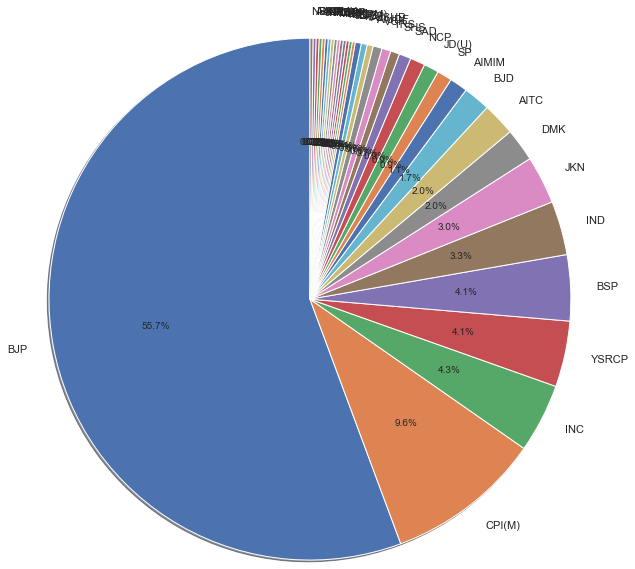

In [98]:
#Lets see different spread across Party for winning candidate
winners = df_elec[df_elec['WINNER'] == 1]

#pie(x, explode, labels, colors, autopct, pctdistance, shadow, labeldistance, startangle, radius, 
#counterclock, wedgeprops, textprops, center, frame, rotatelabels, normalize, data)

chart_labels = winners['PARTY'].unique() 
fig1, ax1 = plt.subplots()
ax1.pie(winners['PARTY'].value_counts(), labels=chart_labels, autopct='%.1f%%',shadow=True, startangle=90,  radius=3)

plt.show()

==> This shows party named 'BJP' is clear winner having more then 50% of the share

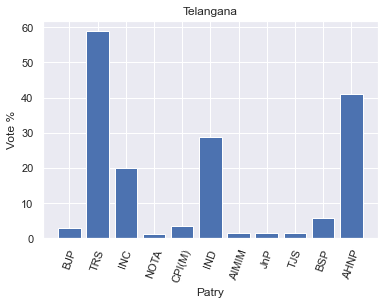

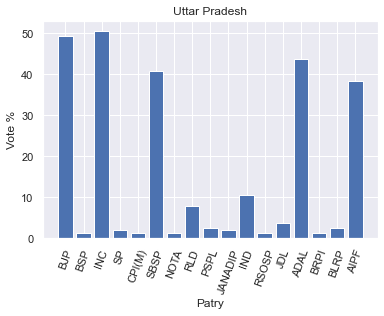

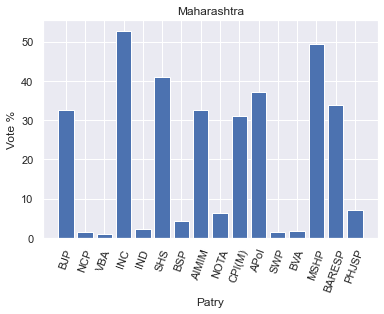

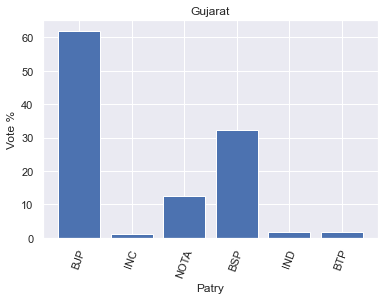

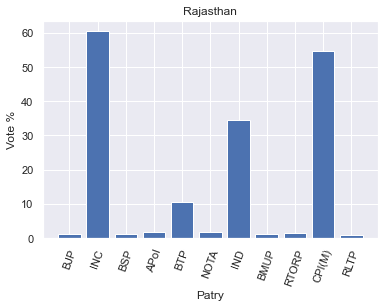

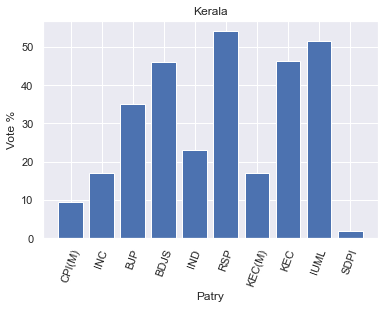

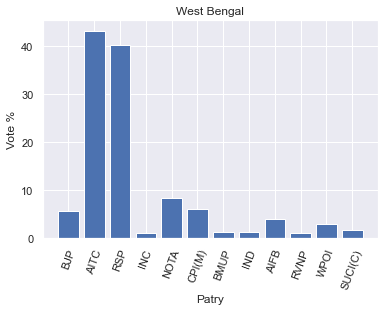

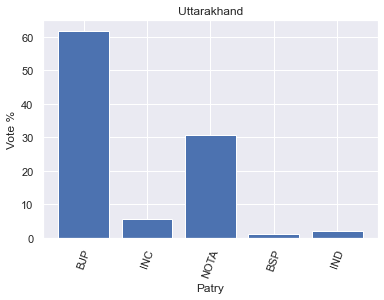

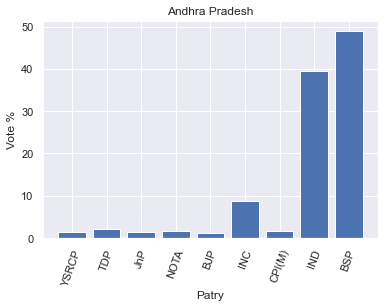

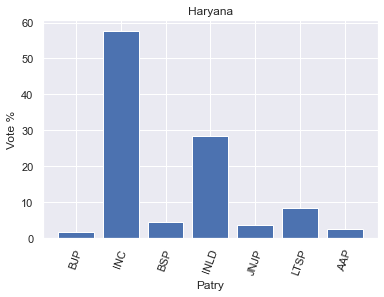

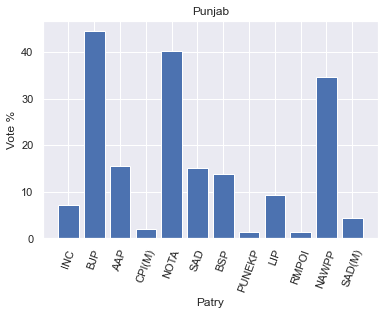

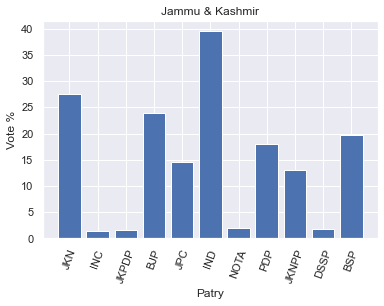

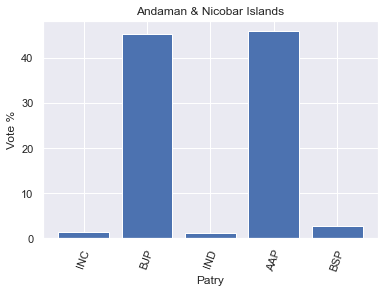

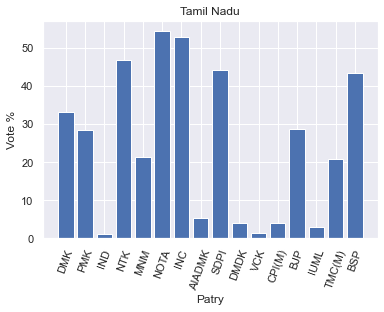

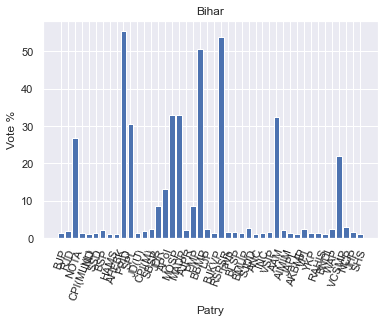

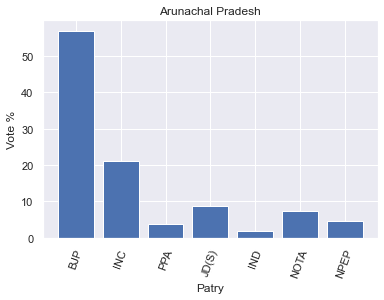

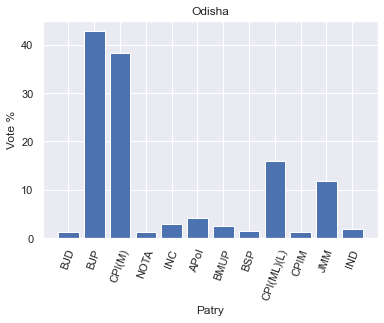

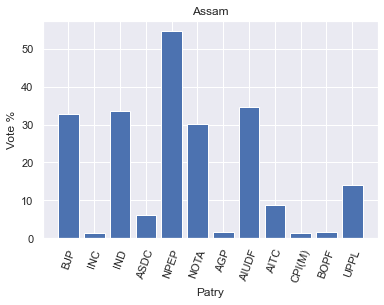

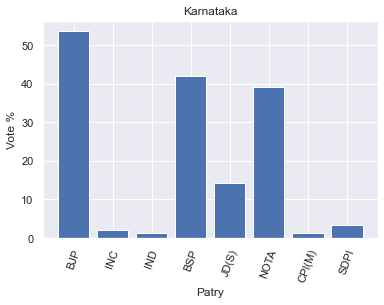

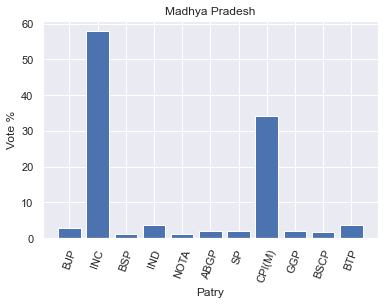

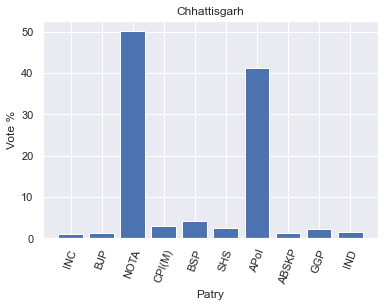

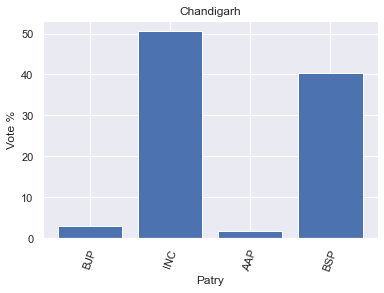

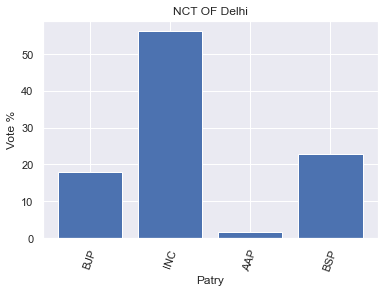

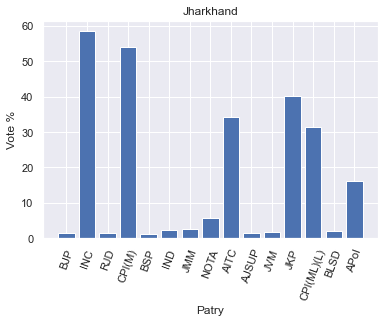

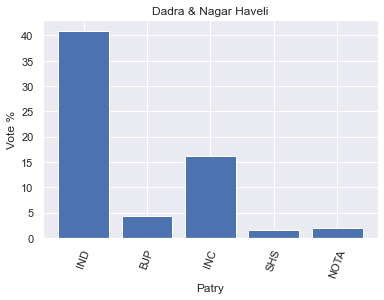

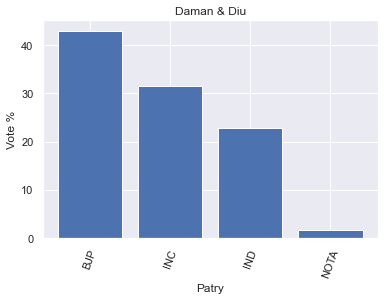

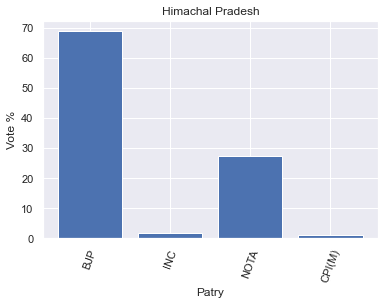

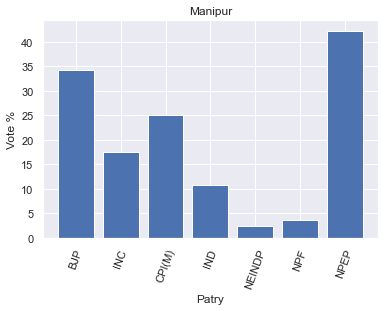

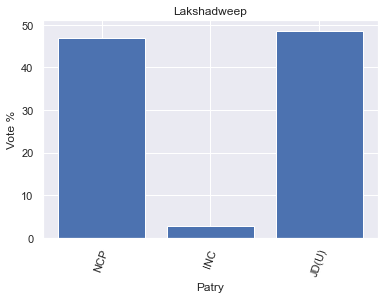

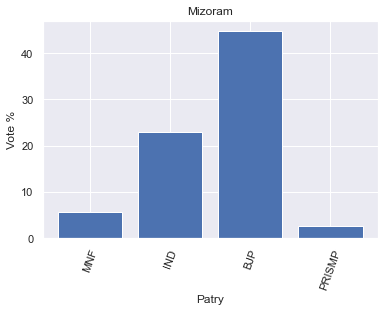

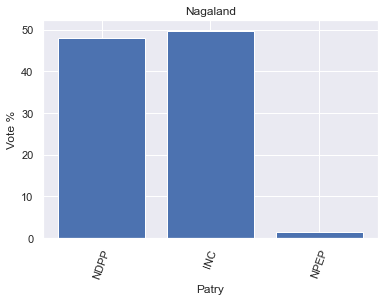

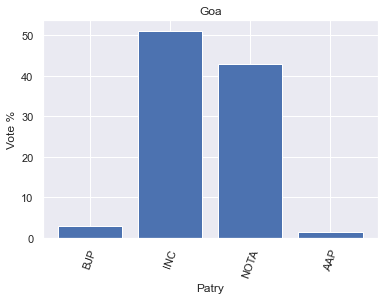

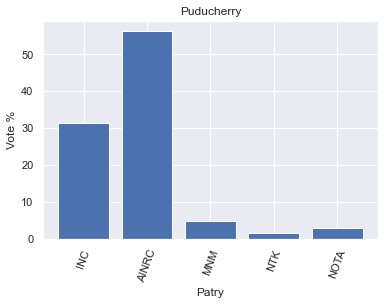

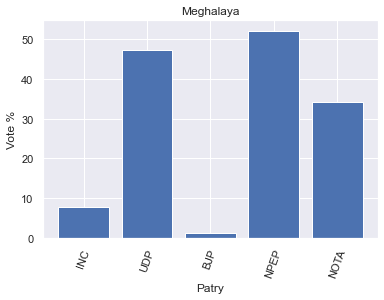

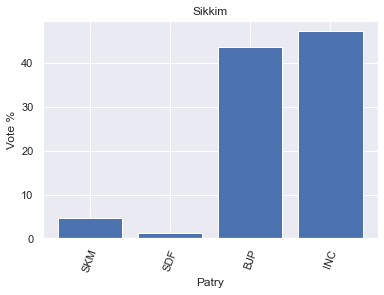

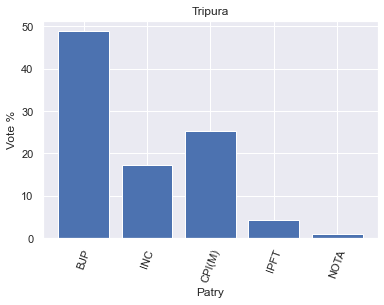

In [99]:
#Lets see if we have major difference in Vote% this will show if the gap was big or thin

df_state = df_elec['STATE'].unique()
for st in df_state:
    df = df_elec[df_elec['STATE'] == st]
    y = df.groupby(["PARTY"])['pct_over_total_vote_poll_in_const'].mean()
    x = df['PARTY'].unique()
    fig1, ax1 = plt.subplots()
    ax1.bar(x,y)
    ax1.set_title(st)
    ax1.set_xlabel("Patry")
    ax1.set_ylabel("Vote %")
    ax1.tick_params(axis='x', rotation=70)
    plt.show()

In [100]:
#For Criminal Cases

df_criminal_cases = df_elec.loc[(df_elec['criminal_cases'].notnull()) & (df_elec['criminal_cases'] != 'Not Available')]
def criminal_cases(row):
    if row['criminal_cases'] == 0:
        return 'No'
    else:
        return 'Yes'
df_criminal_cases['HAS CRIMINAL CASE'] = df_criminal_cases.apply(criminal_cases,axis = 1)
df_criminal_cases_count = df_criminal_cases.groupby(['HAS CRIMINAL CASE','WINNER']).size().reset_index()
df_criminal_cases_count.columns = ['HAS CRIMINAL CASE','WINNER','COUNT']

fig = px.bar(df_criminal_cases_count, x="HAS CRIMINAL CASE", y="COUNT", color='WINNER')
fig.show()

==> This shows candidate with No criminal cases has high chance of winning!

<AxesSubplot:xlabel='EDUCATION', ylabel='count'>

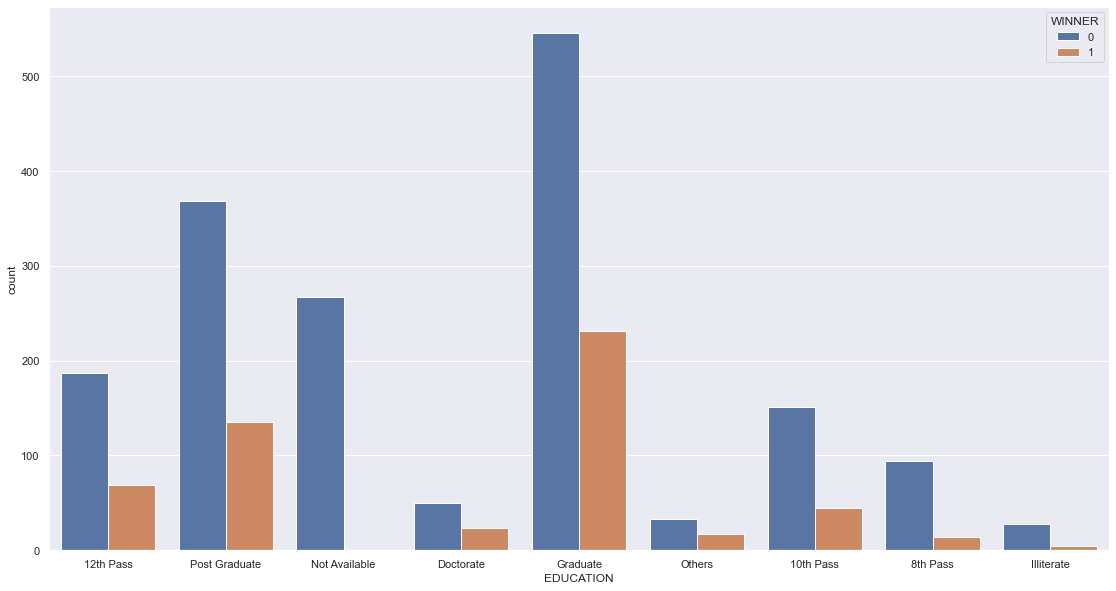

In [101]:
# For Education
plt.figure(figsize=(19,10))
sns.countplot(x=df_elec['EDUCATION'],hue=df_elec['WINNER'])

==> This shows voters like Educated representatives!

### 2.0) Labeling and Preparing Data for model

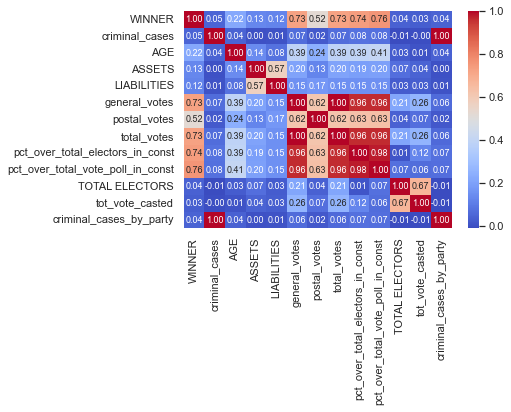

In [102]:
#Let's try to understand if there is corelation between different fetures
# plotting correlation heatmap
dataplot = sns.heatmap(df_elec.corr(), cmap='coolwarm',cbar=True, annot=True,  fmt='.2f', annot_kws={'size': 9})
  
# displaying heatmap
plt.show()

==> You can see there is no relation between Winners and Age, Asset & Criminal cases where as Total_votes is major driver in deciding Winner

In [103]:
# Labeling parties with less than 10 candidates as others
smallcnt_candidates = []
for i, j in df_elec['PARTY'].value_counts().items():
    if j <= 10:
        smallcnt_candidates.append(i)
len(smallcnt_candidates)

def other_party(data):
    if data in smallcnt_candidates:
        return 'Other'
    return data
df_elec['PARTY'] = df_elec['PARTY'].apply(other_party)
df_elec['PARTY'].value_counts()

BJP       420
INC       413
Other     251
NOTA      245
IND       201
BSP       163
CPI(M)    100
VBA        47
AITC       47
SP         39
NTK        38
MNM        36
SHS        26
AAP        25
TDP        25
YSRCP      25
DMK        23
NCP        21
AIADMK     21
RJD        21
BJD        21
JnP        20
JD(U)      18
TRS        17
Name: PARTY, dtype: int64

In [104]:
df_elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   STATE                              2263 non-null   object 
 1   CONSTITUENCY                       2263 non-null   object 
 2   NAME                               2263 non-null   object 
 3   WINNER                             2263 non-null   int64  
 4   PARTY                              2263 non-null   object 
 5   SYMBOL                             2263 non-null   object 
 6   GENDER                             2263 non-null   object 
 7   criminal_cases                     2263 non-null   int32  
 8   AGE                                2263 non-null   float64
 9   CATEGORY                           2263 non-null   object 
 10  EDUCATION                          2263 non-null   object 
 11  ASSETS                             2263 non-null   int64

In [105]:
df1 = df_elec[['STATE','CONSTITUENCY','WINNER','GENDER','criminal_cases','AGE','CATEGORY','EDUCATION','total_votes','TOTAL ELECTORS','ASSETS','LIABILITIES']]
txt_cols = ['STATE','CONSTITUENCY','GENDER','CATEGORY','EDUCATION']
num_cols = ['criminal_cases','AGE','total_votes','TOTAL ELECTORS','ASSETS','LIABILITIES']

In [106]:
df_winner = df1['WINNER'].value_counts().reset_index()
df_winner.columns = ['RESULT','COUNT']
pie = go.Pie(labels=df_winner['RESULT'], values=df_winner['COUNT'])
layout = go.Layout(title='Total Candidates vs Winners')
fig = go.Figure(data=[pie], layout=layout)
py.iplot(fig)

### Data Scalling & Up Sampling

In [107]:
dataset = pd.get_dummies(df1, columns = txt_cols)

standardScaler = StandardScaler()
columns_to_scale = num_cols
dataset[columns_to_scale] = standardScaler.fit_transform(dataset[columns_to_scale])
dataset.head()

,WINNER,criminal_cases,AGE,total_votes,TOTAL ELECTORS,ASSETS,LIABILITIES,STATE_Andaman & Nicobar Islands,STATE_Andhra Pradesh,STATE_Arunachal Pradesh,...,CATEGORY_ST,EDUCATION_10th Pass,EDUCATION_12th Pass,EDUCATION_8th Pass,EDUCATION_Doctorate,EDUCATION_Graduate,EDUCATION_Illiterate,EDUCATION_Not Available,EDUCATION_Others,EDUCATION_Post Graduate
0,1,7.018675,0.272939,0.448506,-0.534986,-0.291905,-0.205143,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,0,-0.179470,0.374295,0.219690,-0.534986,-0.252610,-0.197873,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0.235807,0.272939,0.201809,-0.534986,-0.206583,-0.027182,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,0,-0.179470,-2.362307,-0.975103,-0.534986,-0.299825,-0.207877,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0.512659,0.577006,1.501550,0.889409,-0.110040,-0.106233,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [108]:
#balancing the dataset
df_majority = dataset[dataset.WINNER == 0]
df_minority = dataset[dataset.WINNER == 1]
df_minority_upsampled = resample(df_minority, replace = True,n_samples = 1724, random_state = 0) 
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled.WINNER.value_counts()

0    1724
1    1724
Name: WINNER, dtype: int64

### Model 

Text(0.5, 1.0, 'Random Forest Classifier scores for different K values')

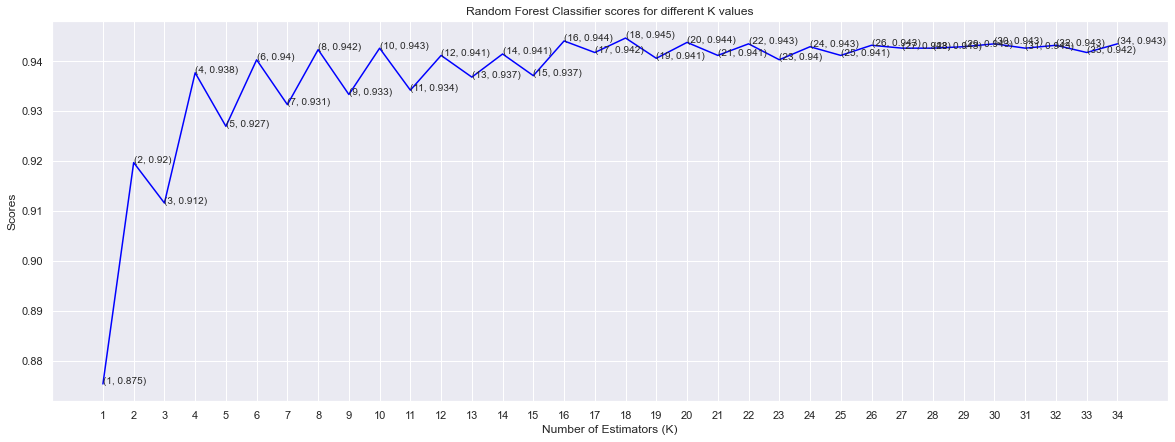

In [109]:
y = df_upsampled['WINNER']
X = df_upsampled.drop(['WINNER'], axis = 1)
max_kval = 35
rfc_scores = []
for k in range(1,max_kval):
    randomforest_classifier= RandomForestClassifier(n_estimators=k,random_state=0)
    score=cross_val_score(randomforest_classifier,X,y,cv=10)
    rfc_scores.append(score.mean())
plt.figure(figsize =(20,7))
plt.plot([k for k in range(1, max_kval)], rfc_scores, color = 'blue')
for i in range(1,max_kval):
    plt.text(i, rfc_scores[i-1], (i, round(rfc_scores[i-1],3)))
plt.xticks([i for i in range(1, max_kval)])
plt.xlabel('Number of Estimators (K)')
plt.ylabel('Scores')
plt.title('Random Forest Classifier scores for different K values')

In [110]:
#As we can see from the graph accuracy is maximum at k =18. Hence we will be selecting n_estimators=18.
K_val=18
randomforest_classifier= RandomForestClassifier(n_estimators=K_val,random_state=0)
score=cross_val_score(randomforest_classifier,X,y,cv=10)
print('% Accuracy :', round(score.mean()*100,1))


% Accuracy : 94.5


In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
rf_model = RandomForestClassifier(n_estimators=K_val, max_features="auto", random_state=0)
rf_model.fit(X_train, y_train)
predicts = rf_model.predict(X_test)
predicts

array([0, 1, 1, ..., 1, 0, 0], dtype=int64)